$\newcommand{\D}[2]{\frac{\partial #1}{\partial #2}}$ $\newcommand{\d}[2]{\partial #1/\partial #2}$
$\newcommand{\DD}[2]{\frac{\partial^2 #1}{\partial {#2}^2}}$ 
$\newcommand{\dd}[2]{\partial^2 #1/\partial {#2}^2}$

# GLM


Let $L(\beta)$ be the log-likelihood of the data $X, y$ as a function of the parameters $\beta$. 

The score (gradient) is the vector 
$$s = \D{L}{\beta}$$ 
with elements $s_i = \partial L/\partial \beta_i$. 


In GLM theory, we assume that the likelihood is a function of an observation vector $y$ and a mean which is a function of the parameters, $\mu(\beta)$, thus

$$
L(\beta) = L(y, \mu(\beta))
$$

Then, using the chain rule, 

$$
s = \D{L}{\beta} = \D{L}{\mu}\D{\mu}{\beta}
$$

The einsum signature is `i,ij->j` where $\beta$ is indexed by j and $\mu$ by i. 

The hessian is

$$
H = \DD{L}{\beta}=\DD{L}{\mu}\DD{\mu}{\beta}
$$

The Fisher information is the expected value of this, 

$$
F = E(H) = E\left(\DD{L}{\beta}\right) = E\left(\D{L}{\beta}\D{L}{\beta*} \right)
$$

(which needs proving) We then have

$$
E\left(\D{L}{\beta}\D{L}{\beta*} \right) = 
E\left(\D{L}{\mu}\D{\mu}{\beta}\D{L}{\mu*}\D{\mu*}{\beta*}\right) =
E\left(\D{L}{\mu}\D{L}{\mu*}\right)\D{\mu}{\beta}\D{\mu*}{\beta*}
$$

The term in the expectation is an outer product since it's over every combination of elements from $\mu$ and $\mu*$. 

## Forward Approach

The example here is for linear regression.

In [1]:
from tracing import *
import forward as fwd

# forward approach for regression

@notrace
def L(y, mu):
    # log-likelihood L as a function of y and mu
    # assuming normally distributed errors
    # mu is a function of b
    return -0.5*np.sum((y-mu)**2) # just an example

# score

@notrace
def L_diff(y, mu, dmu_db):
    # mu is the expected value of y.
    # dm_db is the derivative of mu wrt parameters b
    dLdmu = y-mu # Normally distributed errors
    return np.einsum('i,ij->j', dLdmu, dmu_db)

@fwd.register_deriv(L)
def _L_diff(y, mu):
    # notrace means this becomes an opnode:
    return L_diff(y, mu, value_of(fwd.derivative(mu)))

# fisher

@fwd.register_deriv(L_diff)
def L_mu_diff2(y, mu, deriv_mu):
    dL2_dmu2 = -np.ones((len(y),)) # deriv of y-mu wrt mu
    return np.einsum('ij,i,ik->jk', deriv_mu, dL2_dmu2, deriv_mu)

### Testing.

We'll use ridge regression here

In [2]:
X = np.reshape(np.arange(30), (10,3))
y = np.arange(10)-5.0
b = (np.random.rand(3)+1)

linear = lambda b: X@b

val, j, h = fwd.derivatives_of(lambda b: L(y, linear(b))-10*np.sum(b**2), value=True, jacobian=True, hessian=True)(b)
print(val, '\n', j, '\n', h)

-15039.008355927353 
 [-8768.22117159 -9251.22357064 -9732.32615363] 
 [[-2585. -2700. -2835.]
 [-2700. -2865. -2990.]
 [-2835. -2990. -3165.]]


In [3]:
val, j, h = fwd.derivatives_of(
    lambda b: -0.5*np.sum((y-X@b)**2)-10*np.sum(b**2), value=True, jacobian=True, hessian=True)(b)
print(val, '\n', j, '\n', h)

-15039.008355927353 
 [-8768.22117159 -9251.22357064 -9732.32615363] 
 [[-2585. -2700. -2835.]
 [-2700. -2865. -2990.]
 [-2835. -2990. -3165.]]


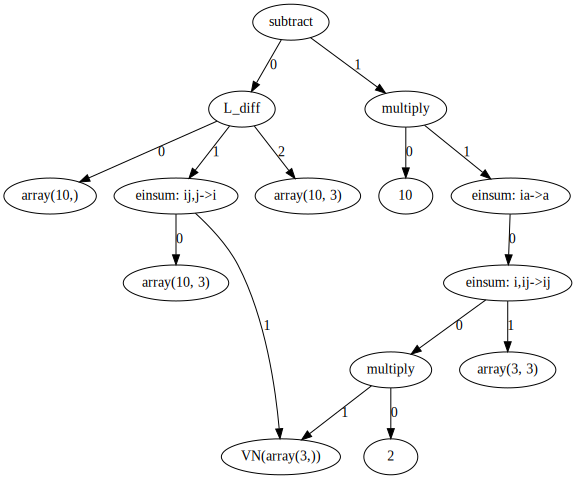

In [4]:
# pretty picture here:

ridge = lambda b: L(y, linear(b))-10*np.sum(b**2)
vn = VarNode(b)
f = ridge(vn)
j = fwd.derivative(f)
graph_fwd(j)

## Reverse Approach.

This is trickier because the jacobian of the mu function must be computed using forward differentiation, for efficiency, and unfortunately that doesn't happen because the jacobian would be computed before dLdmu. So the predictor has to be packaged into the error model to give a function of data & beta.

In [24]:
import reverse as rev

def GLM_Builder(score, dscore, vfunc):
    # creates a GLM likelihood function.
    
    def GLM(predictor):
        # y is the data and predictor is a callable which takes (X,beta)
        # returns a function L(y,X,beta) which is notraced
        
        @notrace
        def L(y, X, b):
            return score(y, predictor(X,b))

        @notrace
        def _dL(y, mu, J, b):
            # works out the derivative of L given mu=predictor(X,b) & its jacobian
            return np.einsum('i,i...->...', dscore(y,mu), J)

        @rev.register_deriv(_dL)
        def _dL2(dYdZ, argno, y, mu, J, b):
            # works out the hessian of L given y, mu=predictor(X,b) and its jacobian
            if argno!=3:
                return 0
            # we aren't going to do any higher derivatives, so just return
            # a matrix
            # if J jas more than 2 dim, we need to allow for this.
            return -dYdZ@np.einsum('i,ij,ik->jk',vfunc(y,mu),J,J)

        @rev.register_deriv(L)
        def dL(dYdZ, argno, y, X, b):
            # function to work out the predictor & jacobian then pass onto
            # the actual derivative. This step is necessary to preserve the
            # value of mu and J
            if argno!=2:
                return 0
            mu, J = fwd.derivatives_of(predictor, argno=1, value=True, jacobian=True)(X, value_of(b))
            # we have to keep b as a parameter here so that it will be traced when
            # computing higher derivatives.
            return dYdZ*_dL(y, mu, J, b)

        return L
    
    return GLM

In [25]:
LinearGLM = GLM_Builder(lambda y,mu:-0.5*np.sum((y-mu)**2), lambda y,mu:y-mu, lambda y,mu:np.ones(y.shape))
g = LinearGLM(lambda X,b:X@b) # g is g(y,X,b)
func = lambda y,X,b: g(y,X,b)-10*np.sum(b**2)
vn = VarNode(b)
f = func(y, X, vn)
graph_fwd(f)
j = rev.derivative(f)
print(value_of(j))
h = rev.derivative(j)
print(value_of(h))

[-8768.22117159 -9251.22357064 -9732.32615363]
[[-2585. -2700. -2835.]
 [-2700. -2865. -2990.]
 [-2835. -2990. -3165.]]


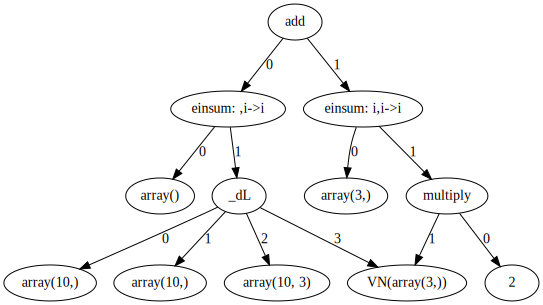

In [28]:
graph_fwd(j)

## Theory
$\newcommand{\D}[2]{\frac{\partial #1}{\partial #2}}$
GLM is based on the log-likelihood $L(\beta)$ of a parameter vector $\beta$. The score (gradient) is a vector $s$ with elements

$$
s_j = \D{L(\beta)}{\beta_j}
$$

The Fisher information is a matrix $F$ with elements 

$$
F_{j,k} = E\left(\frac{\partial L(\beta)}{\partial \beta_j}\frac{\partial L(\beta)}{\partial \beta_k}\right)= E(s_j s_k)
$$

This is approx (or sometimes exactly) the negative hessian.

We assume the data consists of a set of independent observations $y=\{y_1, y_2, y_3, ... y_n\}$, and the likelihood $L$ is the sum of the log-likelihoods of the individual observations, each of which depend on the expected value $\mu_i$

$$
L = \sum_i{l(y_i, \mu_i)}
$$

We further assume that $\mu_i$ is a function $\mu_i(\beta)$ of the parameters $\beta$, so we can write

$$
L = \sum_i{l(y_i, \mu_i)} = \sum_i{l(y_i, \mu_i(\beta))}
$$

There may be further **fixed** parameters in the log-likelihoods such as the number of observations. 

The function $\mu_i(\beta)$ is assumed to be a function of a linear combination of $\beta$. That is, we often assume $\mu_i(\beta)=f(x_{ij}\beta_j)$, using einsum notation. $f$ is called the mean function.

## The score.

By the chain rule,

$$
\begin{align}
s_j &= \sum_i{\D{l_i}{\beta_j}} =\sum_i{\D{l_i}{\mu_i}\D{\mu_i}{\beta_j}}\\
&=\sum_i{\D{l_i}{\mu_i}\D{\mu_i}{\eta_i}\D{\eta_i}{\beta_j}}
\end{align}
$$

The first line gives us what we need when we have a monolithic mean function, and the second line gives the usual breakdown for a mean that is a nonlinear function of $\eta$.

We need to work out the various partial derivatives here. It's usual to skip the $\mu$ part in the development of GLMs, but - for the sake of extensibility - that is not done here.

## The Fisher Info.

The fisher information has elements

$$
\begin{align}
F_{jk} &= E\left(s_js_k\right) \\
       &= E\left(\sum_i{\D{l_i}{\beta_j}}\sum_m{\D{l_m}{\beta_k}}\right) \\
       &= E\left(\sum_i{\D{l_i}{\mu_i}\D{\mu_i}{\beta_j}}\sum_m{\D{l_m}{\mu_m}\D{\mu_m}{\beta_k}}\right) \\
       &= E\left(\sum_{i,m}{\D{l_i}{\mu_i}\D{\mu_i}{\beta_j}\D{l_m}{\mu_m}\D{\mu_m}{\beta_k}}\right) \\
       &= \sum_{i,m}{E\left(\D{l_i}{\mu_i}\D{l_m}{\mu_m}\right)\D{\mu_i}{\beta_j}\D{\mu_m}{\beta_k}} \\
\end{align}
$$

When $i\ne m$ the expectation is zero, so the fisher info is

$$
F_{jk} = \sum_{i}{E\left(\D{l_i}{\mu_i}^2\right)\D{\mu_i}{\beta_j}\D{\mu_i}{\beta_k}} 
$$

### Gaussian Distribution.

N(mu, 1):

$$
l_i \propto -\frac{(y_i-\mu_i)^2}{2}
$$

$$
\D{l_i}{\mu_i} =(y_i-\mu_i)
$$

$$
E\left( \D{l_i}{\mu_i}^2 \right) = 1
$$

### Bernoulli Distribution.

This is a single trial binomial distribuion. The mean $\mu_j$ is the probability of success. $y_j$ is 1 or 0 for success or failure. The likelihood is

$$
l_i = y_i\log{\mu_i}+(1-y_i)\log{1-\mu_i}
$$

$$
\D{l_i}{\mu_i} = \frac{y_i-\mu_i}{\mu_i(1-\mu_i)}
$$

The **logistic** mean function is 

$$
\mu_i = (1+\exp{(-\eta_i)})^{-1}
$$

so 

$$
\D{\mu_i}{\eta_i} = \exp{(-\eta_i)}/(1+\exp{(-\eta_i)})^{-2} = \mu_i(1-\mu_i)
$$

Also, 

$$
\D{\eta_i}{\beta_j} = x_{ij}
$$

Finally,

$$
E\left(\left(\D{l_i}{\mu_i}\right)^2\right) = E\left(\frac{(y_i-\mu_i)^2}{\mu_i^2(1-\mu_i)^2}\right)
= \frac{\mu_i(1-\mu_i)}{\mu_i^2(1-\mu_i)^2} = \frac{1}{\mu_i(1-\mu_i)}
$$

### Poisson Distribution.

$$
l_i \propto y_i\log{\mu_i} -\mu_i
$$

$$
\D{l_i}{\mu_i} = \frac{y_i}{\mu_i}-1 = \frac{y_i-\mu_i}{\mu_i}
$$

$$
E\left( \D{l_i}{\mu_i}^2 \right) = \frac{E((y_i-\mu_i)^2)}{\mu_i^2} = \frac{\mu_i}{\mu_i^2} = \frac{1}{\mu_i}
$$